# Generative Painting Style Using Generative Adversarial Networks (GANs)

---

This project derives from the Kaggle competition with the name Gan Getting Started (I'm Something of a Painter Myself), found here: https://www.kaggle.com/competitions/gan-getting-started/overview

You can find this project at the github repo: https://github.com/chill0121/Kaggle_Projects/tree/main/Adversarial_Painting

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
  - 1.1. [Dataset Information](#data)
  - 1.2. [Kaggle Information](#kaggle)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models**](#models)
  - 5.1. [Model Helper Functions](#helper)
  - 5.2. [Generative Adversarial Network (GAN)](#gan)
- 6.[**Results**](#results)
- 7.[**Conclusion - Kaggle Submission Test Set**](#conclusion)
  - 7.1. [Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Data Information: <a name="data"></a>

Color images (256 x 256 pixels) extracted from histopathologic scans of lymph node sections. These 96 x 96 images are patches of a whole slide image.

- The monet directories contain Monet paintings used to train the model.
- The photo directories contain photos used to add the Monet-style to them for submission.

**Data Info:**
- 300 Monet Painting Images
    - 256 x 256 x 3
- 7028 Photos
    - 256 x 256 x 3

### 1.2. Kaggle Information: <a name="kaggle"></a>

#### Description:

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

#### Evaluation:

MiFID
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better your generated images are.

What is FID?
Originally published here ([github](https://arxiv.org/abs/1706.08500)), FID, along with Inception Score (IS), are both commonly used in recent publications as the standard for evaluation methods of GANs.

#### Citation: 

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [529]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
import torch

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [530]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, sklearn, tf, torch]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'sklearn'  using version: 1.3.2
<module 'tensorflow'  using version: 2.16.2
<module 'torch'  using version: 2.2.2


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [531]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [532]:
img_size = 64

dataset = tf.keras.utils.image_dataset_from_directory(f"{data_folder}/monet_jpg", 
                                                      label_mode = None, 
                                                      image_size = (img_size, img_size), 
                                                      batch_size = 16)
dataset = dataset.map(lambda x: x / 255.0)

Found 300 files.


###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

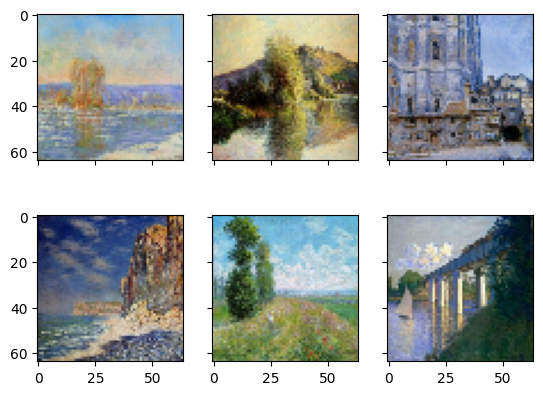

In [533]:
for img in dataset:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    ax[0,0].imshow((img.numpy() * 255).astype(np.uint8)[0])
    ax[0,1].imshow((img.numpy() * 255).astype(np.uint8)[1])
    ax[0,2].imshow((img.numpy() * 255).astype(np.uint8)[2])
    ax[1,0].imshow((img.numpy() * 255).astype(np.uint8)[3])
    ax[1,1].imshow((img.numpy() * 255).astype(np.uint8)[4])
    ax[1,2].imshow((img.numpy() * 255).astype(np.uint8)[5])
    break

In [534]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomCrop(img_size, img_size)
])

In [535]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [536]:
dataset_transformed = prepare(dataset, shuffle=True, augment=True)

In [537]:
dataset_transformed

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

(64, 64, 3)


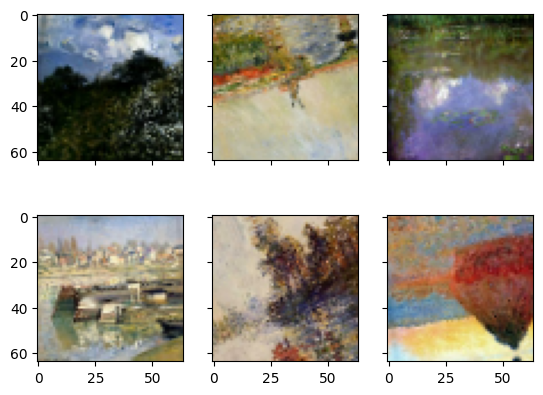

In [538]:
for img in dataset_transformed:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    print((img.numpy() * 255).astype(np.uint8)[0].shape)
    ax[0,0].imshow((img.numpy() * 255).astype(np.uint8)[0])
    ax[0,1].imshow((img.numpy() * 255).astype(np.uint8)[1])
    ax[0,2].imshow((img.numpy() * 255).astype(np.uint8)[2])
    ax[1,0].imshow((img.numpy() * 255).astype(np.uint8)[3])
    ax[1,1].imshow((img.numpy() * 255).astype(np.uint8)[4])
    ax[1,2].imshow((img.numpy() * 255).astype(np.uint8)[5])
    break

###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

###### [Back to Table of Contents](#toc)

## 5. Models <a name="models"></a>

---

###### [Back to Table of Contents](#toc)

### 5.1. Model Helper Functions <a name="helper"></a>

###### [Back to Table of Contents](#toc)

### 5.2. Generative Adversarial Network (GAN) <a name="gan"></a>

In [539]:
discriminator = tf.keras.Sequential(
       [tf.keras.Input(shape=(img_size, img_size, 3)),
        tf.keras.layers.Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation = 'sigmoid')],
    name = 'discriminator')

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_90 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_91 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_92 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [540]:
latent_dim = 128
generator = tf.keras.Sequential(
       [tf.keras.Input(shape = (latent_dim,)),
        tf.keras.layers.Dense(8 * 8 * 128),
        tf.keras.layers.Reshape((8, 8, 128)),
        tf.keras.layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Conv2D(3, kernel_size = 5, padding = 'same', activation = 'sigmoid')],
    name = 'generator')
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_93 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_46             │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_94 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_47             │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_95 (LeakyReLU)      │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [541]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = tf.keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.keras.ops.shape(real_images)[0]
        random_latent_vectors = tf.keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.keras.ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.keras.ops.concatenate(
            [tf.keras.ops.ones((batch_size, 1)), tf.keras.ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = tf.keras.ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [542]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = tf.keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save(f"{current_wdir}/Generated_Images/gen_img_{epoch:03}_{i}.png")

In [543]:
epochs = 250  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

history_gan = gan.fit(dataset_transformed, epochs=epochs,# steps_per_epoch = dataset_transformed.cardinality().numpy(),
                       callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - d_loss: 0.6864 - g_loss: 0.7339
Epoch 2/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - d_loss: 0.6605 - g_loss: 0.7424
Epoch 3/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - d_loss: 0.6926 - g_loss: 0.7633
Epoch 4/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - d_loss: 0.5803 - g_loss: 0.8476
Epoch 5/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - d_loss: 0.6387 - g_loss: 0.9234
Epoch 6/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - d_loss: 0.4567 - g_loss: 1.2581
Epoch 7/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - d_loss: 0.3670 - g_loss: 2.1619
Epoch 8/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - d_loss: 1.4515 - g_loss: 0.5116
Epoch 9/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - d_loss: 0.8156 - g_loss: 0.8215
Epoch 10/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - d_loss: 0.3222 - g_loss: 1.5973
Epoch 11/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - d_loss: 0.3619 - g_loss: 1.4667
Epoch 12/250
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - d_loss: 0

In [544]:
photos = tf.keras.utils.image_dataset_from_directory(
    f"{data_folder}/photo_jpg", label_mode = None, image_size = (img_size, img_size), batch_size = 16
)
photos = photos.map(lambda x: x / 255.0)

Found 7038 files.


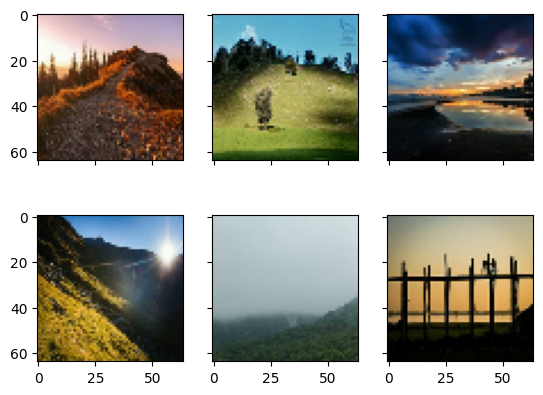

In [545]:
for img in photos:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    ax[0,0].imshow((img.numpy() * 255).astype(np.uint8)[0])
    ax[0,1].imshow((img.numpy() * 255).astype(np.uint8)[1])
    ax[0,2].imshow((img.numpy() * 255).astype(np.uint8)[2])
    ax[1,0].imshow((img.numpy() * 255).astype(np.uint8)[3])
    ax[1,1].imshow((img.numpy() * 255).astype(np.uint8)[4])
    ax[1,2].imshow((img.numpy() * 255).astype(np.uint8)[5])
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


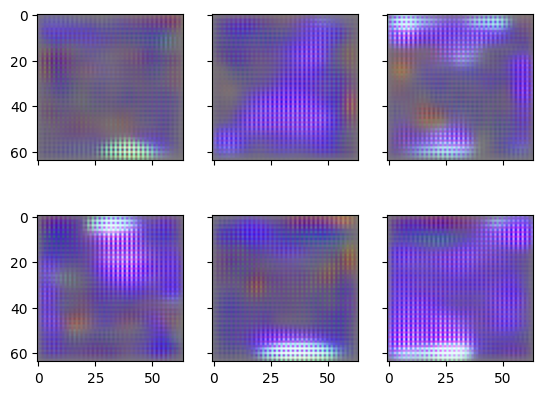

In [594]:
for img in photos:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    prediction = generator.predict(np.random.normal(size = (6,128)))
    ax[0,0].imshow((prediction * 255).astype(np.uint8)[0])
    ax[0,1].imshow((prediction * 255).astype(np.uint8)[1])
    ax[0,2].imshow((prediction * 255).astype(np.uint8)[2])
    ax[1,0].imshow((prediction * 255).astype(np.uint8)[3])
    ax[1,1].imshow((prediction * 255).astype(np.uint8)[4])
    ax[1,2].imshow((prediction * 255).astype(np.uint8)[5])
    break

###### [Back to Table of Contents](#toc)

## 6. Results <a name="results"></a>

---

In [547]:
# Highlight the best model's test results green at each proportion.
def max_value_highlight(df):
    max_test_rows = df.max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df):
    # Sort values
    test_rows = df
    sorted_df = test_rows.sort_values(ascending = False)
    top_two = sorted_df.iloc[: 2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

To evaluate the test set the .csv files must be submitted to Kaggle. Each model's predictions were saved above and manually submitted. Below you can find a screenshot of all the results.

<img src="https://github.com/chill0121/Kaggle_Projects/blob/main/Cancer_Detection_Histopathology/Models/Kaggle_Submission_Scores.png?raw=true" alt="results" width="1000"/>

###### [Back to Table of Contents](#toc)

## 7. Conclusion - Kaggle Submission Test Set <a name="conclusion"></a>

---


### 7.1. Possible Areas for Improvement <a name="improvements"></a>

- 

###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

 Exported to HTML via command line using:

- `jupyter nbconvert Adversarial_Painting.ipynb --to html`
- `jupyter nbconvert Adversarial_Painting.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)